# 10.5 LightGBM算法案例实战1 - 客户违约预测模型

**10.5.1 案例背景**

银行等金融机构经常会根据客户的个人资料、财产等情况，来预测借款客户是否会违约，从而进行贷前审核，贷中管理，贷后违约处理等工作。金融处理的就是风险，需要在风险和收益间寻求到一个平衡点，现代金融某种程度上便是一个风险定价的过程，通过个人的海量数据，从而对其进行风险评估并进行合适的借款利率定价，这便是一个典型的风险定价过程，这也被称之为大数据风控。

**10.5.2 模型搭建**

In [1]:
# 1.读取数据
import pandas as pd
df = pd.read_excel('客户信息及违约表现.xlsx')
df.head()

,收入,年龄,性别,历史授信额度,历史违约次数,是否违约
0,462087,26,1,0,1,1
1,362324,32,0,13583,0,1
2,332011,52,1,0,1,1
3,252895,39,0,0,1,1
4,352355,50,1,0,0,1


In [2]:
# 2.提取特征变量和目标变量
X = df.drop(columns='是否违约')
Y = df['是否违约']

# 3.划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

# 4.模型训练及搭建
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [3]:
# 通过如下代码可以查看官方讲解
# LGBMClassifier?

**10.5.3 模型预测及评估**

In [4]:
# 预测测试集数据
y_pred = model.predict(X_test)
print(y_pred)

[1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0
 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0
 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1]


In [5]:
# 预测值和实际值对比
a = pd.DataFrame()  # 创建一个空DataFrame 
a['预测值'] = list(y_pred)
a['实际值'] = list(y_test)
a.head()

,预测值,实际值
0,1,1
1,0,1
2,1,1
3,0,0
4,0,1


In [6]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
score

0.795

In [7]:
# 查看得分
model.score(X_test, y_test)

0.795

In [8]:
# 查看预测属于各个分类的概率
y_pred_proba = model.predict_proba(X_test)

# 绘制ROC曲线
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

<Figure size 640x480 with 1 Axes>

In [9]:
# AUC值
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred_proba[:,1])
score

0.82250025429763

In [10]:
# 特征重要性
model.feature_importances_

array([1127,  655,  134,  874,  154])

In [11]:
features = X.columns  # 获取特征名称
importances = model.feature_importances_  # 获取特征重要性

# 通过二维表格形式显示
importances_df = pd.DataFrame()
importances_df['特征名称'] = features
importances_df['特征重要性'] = importances
importances_df.sort_values('特征重要性', ascending=False)

,特征名称,特征重要性
0,收入,1127
3,历史授信额度,874
1,年龄,655
4,历史违约次数,154
2,性别,134


**10.5.4 模型参数调优**

In [12]:
# 参数调优
from sklearn.model_selection import GridSearchCV  # 网格搜索合适的超参数
parameters = {'num_leaves': [10, 15, 31], 'n_estimators': [10, 20, 30], 'learning_rate': [0.05, 0.1, 0.2]}
model = LGBMClassifier()  # 构建分类器
grid_search = GridSearchCV(model, parameters, scoring='roc_auc', cv=5)  # cv=5表示交叉验证5次，scoring='roc_auc'表示以ROC曲线的AUC评分作为模型评价准则

In [13]:
# 输出参数最优值
grid_search.fit(X_train, y_train)  # 传入数据
grid_search.best_params_  # 输出参数的最优值

{'learning_rate': 0.05, 'n_estimators': 30, 'num_leaves': 10}

In [14]:
# 重新搭建分类器
model = LGBMClassifier(num_leaves=15, n_estimators=20,learning_rate=0.1)
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=20, n_jobs=-1, num_leaves=15, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

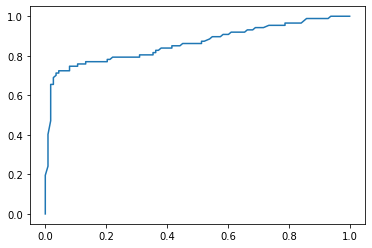

In [15]:
# 查看ROC曲线
y_pred_proba = model.predict_proba(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(y_test, y_pred_proba[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.show()

In [16]:
# 查看AUC值
y_pred_proba = model.predict_proba(X_test)
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred_proba[:, 1])
score

0.8615603702573491